In [20]:
!pip install -q rpy2

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Get Data

We will apply the KNN approach to the Caravan data set, which is part of the ISLR library. This data set includes 85 predictors that measure demographic characteristics for 5,822 individuals. The response variable is Purchase, which indicates whether or not a given individual purchases a Caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.



In [22]:
%%R

install.packages('ISLR',repos = 'http://cran.us.r-project.org')
library(ISLR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/ISLR_1.4.tar.gz'
Content type 'application/x-gzip' length 1756715 bytes (1.7 MB)
downloaded 1.7 MB


The downloaded source packages are in
	‘/tmp/RtmpKvWHr9/downloaded_packages’


In [23]:
%%R

str(Caravan)

'data.frame':	5822 obs. of  86 variables:
 $ MOSTYPE : num  33 37 37 9 40 23 39 33 33 11 ...
 $ MAANTHUI: num  1 1 1 1 1 1 2 1 1 2 ...
 $ MGEMOMV : num  3 2 2 3 4 2 3 2 2 3 ...
 $ MGEMLEEF: num  2 2 2 3 2 1 2 3 4 3 ...
 $ MOSHOOFD: num  8 8 8 3 10 5 9 8 8 3 ...
 $ MGODRK  : num  0 1 0 2 1 0 2 0 0 3 ...
 $ MGODPR  : num  5 4 4 3 4 5 2 7 1 5 ...
 $ MGODOV  : num  1 1 2 2 1 0 0 0 3 0 ...
 $ MGODGE  : num  3 4 4 4 4 5 5 2 6 2 ...
 $ MRELGE  : num  7 6 3 5 7 0 7 7 6 7 ...
 $ MRELSA  : num  0 2 2 2 1 6 2 2 0 0 ...
 $ MRELOV  : num  2 2 4 2 2 3 0 0 3 2 ...
 $ MFALLEEN: num  1 0 4 2 2 3 0 0 3 2 ...
 $ MFGEKIND: num  2 4 4 3 4 5 3 5 3 2 ...
 $ MFWEKIND: num  6 5 2 4 4 2 6 4 3 6 ...
 $ MOPLHOOG: num  1 0 0 3 5 0 0 0 0 0 ...
 $ MOPLMIDD: num  2 5 5 4 4 5 4 3 1 4 ...
 $ MOPLLAAG: num  7 4 4 2 0 4 5 6 8 5 ...
 $ MBERHOOG: num  1 0 0 4 0 2 0 2 1 2 ...
 $ MBERZELF: num  0 0 0 0 5 0 0 0 1 0 ...
 $ MBERBOER: num  1 0 0 0 4 0 0 0 0 0 ...
 $ MBERMIDD: num  2 5 7 3 0 4 4 2 1 3 ...
 $ MBERARBG: num  5 0 0 

In [24]:
%%R

summary(Caravan$Purchase)

  No  Yes 
5474  348 


# Cleaning Data

In [25]:
%%R

any(is.na(Caravan))

[1] FALSE


# Standardize Variables

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale.



let's check out the variance of two features

In [26]:
%%R

var(Caravan[,1])

[1] 165.0378


In [27]:
%%R

var(Caravan[,2])

[1] 0.1647078


Clearly the scales are different! We are now going to standarize all the X variables except Y (Purchase). The Purchase variable is in column 86 of our dataset, so let’s save it in a separate variable because the knn() function needs it as a separate argument.



In [28]:
%%R

# save the Purchase column in a separate variable
purchase <- Caravan[,86]

# Standarize the dataset using "scale()" R function
standardized.Caravan <- scale(Caravan[,-86])

Let's check the variance again

In [29]:
%%R

var(standardized.Caravan[,1])

[1] 1


In [30]:
%%R

var(standardized.Caravan[,2])

[1] 1


We can see that now that all independent variables (X’s) have a mean of 1 and standard deviation of 0. Great, then let’s divide our dataset into testing and training data. We'll just do a simple split of the first 1000 rows as a test set

In [31]:
%%R

# First 100 rows for test set
test.index <- 1:1000
test.data <- standardized.Caravan[test.index,]
test.purchase <- purchase[test.index]

In [32]:
%%R

# Rest of data for training
train.data <- standardized.Caravan[-test.index,]
train.purchase <- purchase[-test.index]

# Using KNN
Rememeber that we are trying to come up with a model to predict whether someone will purchase or not. We will use the knn() function to do so, and we will focus on 4 of its arguments that we need to specify. The first argument is a data frame that contains the training data set(remember that we don’t have the Y here), the second argument is a data frame that contains the testing data set (again no Y variable), the third argument is the train.purchase column (Y) that we save earlier, and the fourth argument is the k (how many neighbors). Let’s start with k = 1. knn() function returns a vector of predicted Y’s.

In [33]:
%%R

library(class)

In [34]:
%%R

set.seed(101)
predicted.purchase <- knn(train.data,test.data,train.purchase,k=1)
head(predicted.purchase)

[1] No No No No No No
Levels: No Yes


Now let’s evaluate the model we trained and see our misclassification error rate.



In [35]:
%%R

mean(test.purchase != predicted.purchase)

[1] 0.116


# Choosing K Value
Let's see what happens when we choose a different K value

In [36]:
%%R

predicted.purchase <- knn(train.data,test.data,train.purchase,k=3)
mean(test.purchase != predicted.purchase)

[1] 0.073


In [37]:
%%R

predicted.purchase <- knn(train.data,test.data,train.purchase,k=5)
mean(test.purchase != predicted.purchase)

[1] 0.066


let’s automate the process with a for() loop.


In [38]:
%%R

predicted.purchase = NULL
error.rate = NULL

for(i in 1:20){
    set.seed(101)
    predicted.purchase = knn(train.data,test.data,train.purchase,k=i)
    error.rate[i] = mean(test.purchase != predicted.purchase)
}

In [39]:
%%R

print(error.rate)

 [1] 0.116 0.107 0.074 0.070 0.066 0.064 0.062 0.061 0.058 0.058 0.059 0.058
[13] 0.059 0.059 0.059 0.059 0.059 0.059 0.059 0.059


# Elbow Method
We can plot out the various error rates for the K values. We should see an "elbow" indicating that we don't get a decrease in error rate for using a higher K. This is a good cut-off point

In [40]:
%%R

library(ggplot2)

In [41]:
%%R

k.values <- 1:20

In [42]:
%%R

error.df <- data.frame(error.rate,k.values)

In [43]:
%%R

error.df

   error.rate k.values
1       0.116        1
2       0.107        2
3       0.074        3
4       0.070        4
5       0.066        5
6       0.064        6
7       0.062        7
8       0.061        8
9       0.058        9
10      0.058       10
11      0.059       11
12      0.058       12
13      0.059       13
14      0.059       14
15      0.059       15
16      0.059       16
17      0.059       17
18      0.059       18
19      0.059       19
20      0.059       20


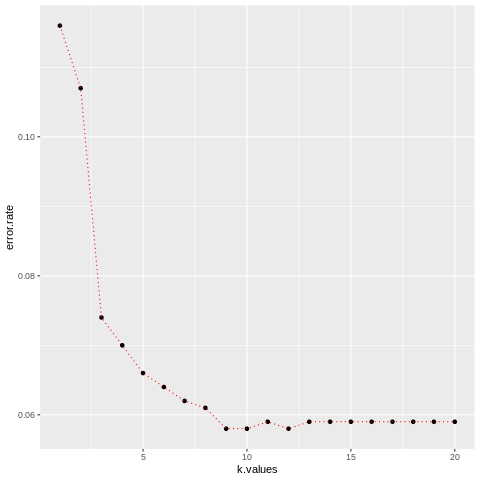

In [44]:
%%R

ggplot(error.df,aes(x=k.values,y=error.rate)) + geom_point()+ geom_line(lty="dotted",color='red')